### Trader Performance vs Market Sentiment Analysis
### Primetrade.ai - Data Science Intern Assignment

In [ ]:
# Basic imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)


### PART-A : DATA PREPARATION

In [28]:
# Load Datasets 

df_sentiment = pd.read_csv('fear_greed_index.csv')
df_traders = pd.read_csv('historical_data.csv')

In [29]:
print("Shape of Sentiment Data :",df_sentiment.shape)
print("Shape of Trader Data",df_traders.shape)

Shape of Sentiment Data : (2644, 4)
Shape of Trader Data (211224, 16)


In [17]:
# Datasets Documentation

print("SENTIMENT DATASET:")
print("Rows:",df_sentiment.shape[0])
print("Columns:",df_sentiment.shape[1])
print("Missing values:",df_sentiment.isnull().sum().sum())
print("Duplicates:",df_sentiment.duplicated().sum())

print("TRADER DATASET:")
print("Rows:",df_traders.shape[0])
print("Columns:",df_traders.shape[1])
print("Missing values:",df_traders.isnull().sum().sum())
print("Duplicates:",df_traders.duplicated().sum())
print("Unique Accounts:",df_traders['Account'].nunique())
print("Unique Coins:",df_traders['Coin'].nunique())

SENTIMENT DATASET:
Rows: 2644
Columns: 4
Missing values: 0
Duplicates: 0
TRADER DATASET:
Rows: 211224
Columns: 16
Missing values: 0
Duplicates: 0
Unique Accounts: 32
Unique Coins: 246


In [18]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


<Axes: xlabel='classification'>

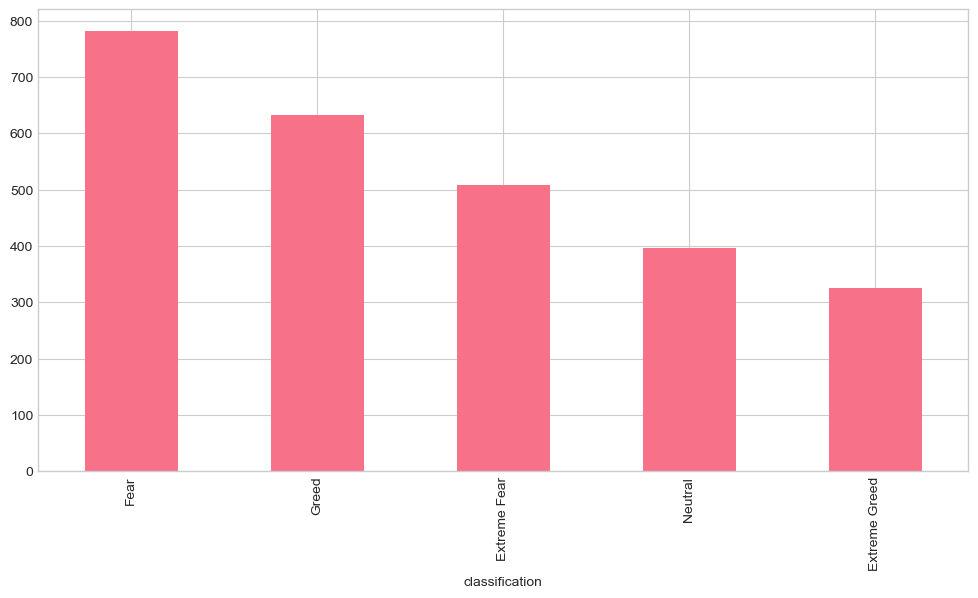

In [56]:
df_sentiment['classification'].value_counts().plot(kind='bar')

In [43]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])


# Convert trader timestamps (from milliseconds to datetime)
df_traders['datetime'] = pd.to_datetime(df_traders['Timestamp'], unit='ms')
df_traders['date'] = df_traders['datetime'].dt.date
df_traders['date'] = pd.to_datetime(df_traders['date'])
df_traders['hour'] = df_traders['datetime'].dt.hour

print(f" Sentiment range: {df_sentiment['date'].min()} to {df_sentiment['date'].max()}")
print(f" Trader range: {df_traders['date'].min()} to {df_traders['date'].max()}")

 Sentiment range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
 Trader range: 2023-03-28 00:00:00 to 2025-06-15 00:00:00


In [50]:
df_traders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   Execution Price   211224 non-null  float64       
 3   Size Tokens       211224 non-null  float64       
 4   Size USD          211224 non-null  float64       
 5   Side              211224 non-null  object        
 6   Timestamp IST     211224 non-null  object        
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   Closed PnL        211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  Fee               211224 non-null  float64       
 14  Trad

<Axes: xlabel='Side'>

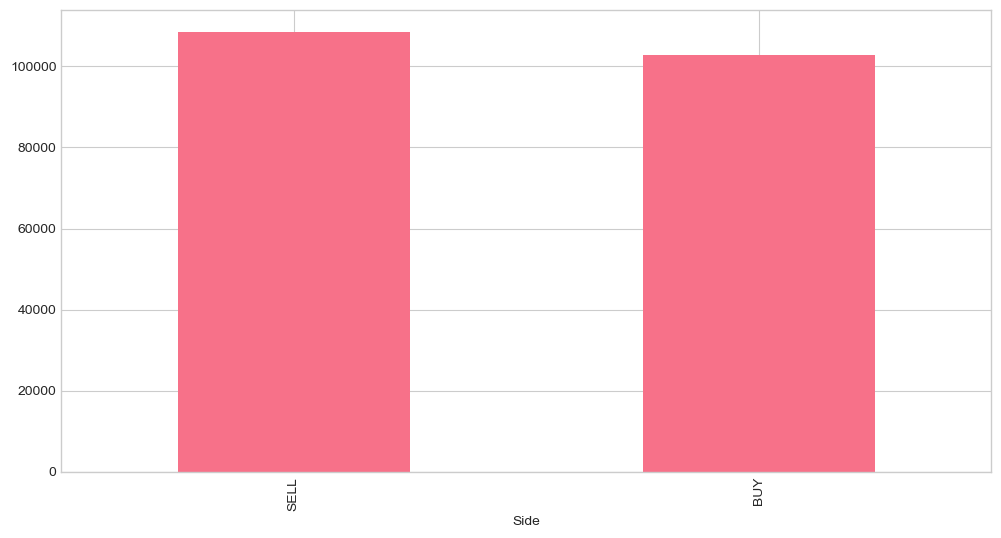

In [60]:

df_traders['Side'].value_counts().plot(kind='bar')

<Axes: xlabel='Direction'>

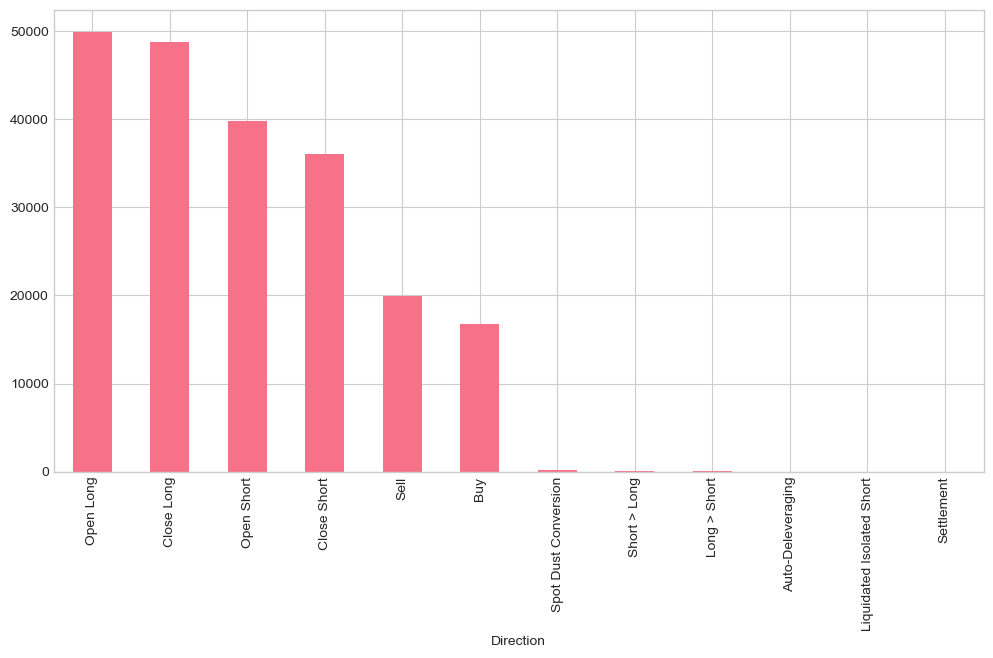

In [48]:
df_traders['Direction'].value_counts().plot(kind='bar')

In [61]:
df_traders['position_type'] = df_traders['Direction'].apply(
        lambda x: 'Long' if 'Long' in str(x) else ('Short' if 'Short' in str(x) else 'Other')
    )

<Axes: xlabel='position_type'>

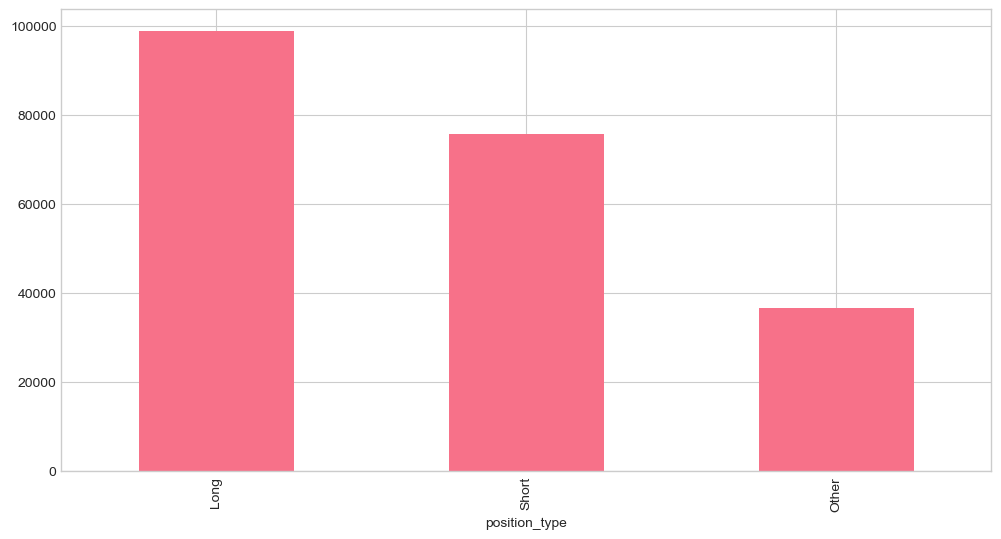

In [63]:
df_traders['position_type'].value_counts().plot(kind='bar')

In [68]:
daily_metrics = df_traders.groupby(['Account', 'date']).agg({
        'Closed PnL': ['sum', 'mean', 'std', 'min', 'max'],
        'Trade ID': 'count',
        'Size USD': ['sum', 'mean'],
        'Fee': 'sum',
        'Size Tokens': 'mean'
    }).round(4)

daily_metrics.columns = [
        'daily_pnl', 'avg_pnl_per_trade', 'pnl_volatility', 'min_pnl', 'max_pnl',
        'num_trades', 'total_volume_usd', 'avg_trade_size_usd', 'total_fees',
        'avg_trade_size_tokens'
    ]

daily_metrics = daily_metrics.reset_index()

In [71]:
# Win rate
win_rate = df_traders.groupby(['Account', 'date']).apply(lambda x: (x['Closed PnL'] > 0).sum() / len(x) if len(x) > 0 else 0).reset_index()
win_rate.columns = ['Account', 'date', 'win_rate']
daily_metrics = daily_metrics.merge(win_rate, on=['Account', 'date'], how='left')
    
# Long/short ratio    
long_short = df_traders[df_traders['position_type'].isin(['Long', 'Short'])]\
    .groupby(['Account', 'date', 'position_type']).size().unstack(fill_value=0)
    
if 'Long' in long_short.columns and 'Short' in long_short.columns:
    long_short['long_short_ratio'] = (long_short['Long'] / (long_short['Short'] + 1)).round(4)
    long_short = long_short.reset_index()[['Account', 'date', 'long_short_ratio']]
    daily_metrics = daily_metrics.merge(long_short, on=['Account', 'date'], how='left')

In [72]:
# Merge with sentiment

df_merged = daily_metrics.merge(
    df_sentiment[['date', 'value', 'classification']],
    on='date',
    how='left'
)


    

In [76]:
df_merged['classification'].isnull().sum()

np.int64(25)

In [77]:
df_merged['classification'] = df_merged['classification'].fillna('Unknown')
    
print(f"Merged shape: {df_merged.shape}")
print(f"With sentiment: {(df_merged['classification'] != 'Unknown').sum()}")
    
# Save processed data
df_merged.to_csv('processed_data.csv', index=False)

Merged shape: (102, 16)
With sentiment: 77


In [78]:
df_merged

,Account,date,daily_pnl,avg_pnl_per_trade,pnl_volatility,min_pnl,max_pnl,num_trades,total_volume_usd,avg_trade_size_usd,total_fees,avg_trade_size_tokens,win_rate,long_short_ratio,value,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,-708.8872,5734.4731,-117990.1041,883.7570,462,6842632.02,14810.8918,1112.8956,12.2965,0.025974,0.0000,74.0,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,574.4147,4509.2568,-19841.2401,135329.0901,3356,54854631.95,16345.2419,6292.4167,16.7001,0.405542,0.2050,44.0,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,64.3983,214.0059,0.0000,2325.6884,320,797679.97,2492.7499,202.1672,129.5396,0.531250,34.0000,74.0,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,4.8397,176.8547,-6820.7696,4037.8720,3533,5982611.50,1693.3517,1664.9147,851.7959,0.435041,0.7312,44.0,Fear
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,2.9703,36.7930,-1162.0263,549.0000,3427,5255196.19,1533.4684,862.7561,178.4321,0.442369,1.5773,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-02-19,3.254420e+05,147.1922,1598.4388,-24500.0000,32783.5294,2211,17917884.11,8103.9729,3999.8539,4324.1156,0.372230,0.6682,44.0,Fear
98,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-06-15,-1.165946e+05,-715.3043,1601.2596,-11199.6361,1.0700,163,2091724.18,12832.6637,692.0172,434.3804,0.006135,0.0186,NaN,Unknown
99,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2024-10-27,6.842150e+05,69.2315,519.6044,-22634.4634,22883.5125,9883,26617723.76,2693.2838,2512.0073,109.5931,0.569260,0.1739,74.0,Greed
100,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-02-19,1.269680e+05,4.7641,61.2427,-2044.4000,1685.5817,26651,41437969.80,1554.8373,9512.3176,92.5136,0.384864,1.4688,44.0,Fear


### PART-B : ANALYSIS

In [80]:
df_known = df_merged[df_merged['classification'] != 'Unknown'].copy()
df_known['sentiment'] = df_known['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else ('Greed' if 'Greed' in x else 'Neutral')
)

In [81]:
df_known['sentiment'].value_counts()

sentiment
Greed      37
Fear       32
Neutral     8
Name: count, dtype: int64

In [82]:
# Q1: Performance by sentiment
fear_data = df_known[df_known['sentiment'] == 'Fear']
greed_data = df_known[df_known['sentiment'] == 'Greed']

In [83]:
print("\nDaily PnL Comparison:")
print(f"   Fear:  Mean=${fear_data['daily_pnl'].mean():,.0f}, Median=${fear_data['daily_pnl'].median():,.0f}")
print(f"   Greed: Mean=${greed_data['daily_pnl'].mean():,.0f}, Median=${greed_data['daily_pnl'].median():,.0f}")


Daily PnL Comparison:
   Fear:  Mean=$209,373, Median=$81,390
   Greed: Mean=$90,989, Median=$20,926


In [86]:
t_stat, p_val = stats.ttest_ind(fear_data['daily_pnl'], greed_data['daily_pnl'])
print(f"   P-value: {p_val:.4f} {'Significant' if p_val < 0.05 else 'Not significant'}")
    
print("\nWin Rate Comparison:")
print(f"   Fear:  {fear_data['win_rate'].mean():.1%}")
print(f"   Greed: {greed_data['win_rate'].mean():.1%}")

   P-value: 0.1342 Not significant

Win Rate Comparison:
   Fear:  41.6%
   Greed: 36.9%


In [89]:
# Q2: Behavioral changes

print("Trade Frequency:")
print(f"Fear:  {fear_data['num_trades'].mean():,.0f} trades/day")
print(f"Greed: {greed_data['num_trades'].mean():,.0f} trades/day")
t_stat, p_val = stats.ttest_ind(fear_data['num_trades'], greed_data['num_trades'])
print(f"Difference: {((fear_data['num_trades'].mean() / greed_data['num_trades'].mean()) - 1) * 100:.1f}%")
print(f"P-value: {p_val:.4f} {'Significant' if p_val < 0.05 else 'Not significant'}")
print("--"*40)    
print("\nTrading Volume:")
print(f"Fear:  ${fear_data['total_volume_usd'].mean():,.0f}")
print(f"Greed: ${greed_data['total_volume_usd'].mean():,.0f}")
t_stat, p_val = stats.ttest_ind(fear_data['total_volume_usd'], greed_data['total_volume_usd'])
print(f"Difference: {((fear_data['total_volume_usd'].mean() / greed_data['total_volume_usd'].mean()) - 1) * 100:.1f}%")
print(f"P-value: {p_val:.4f} {'Significant' if p_val < 0.05 else 'Not significant'}")

Trade Frequency:
Fear:  4,183 trades/day
Greed: 1,169 trades/day
Difference: 257.9%
P-value: 0.0039 Significant
--------------------------------------------------------------------------------

Trading Volume:
Fear:  $22,004,953
Greed: $4,186,769
Difference: 425.6%
P-value: 0.0050 Significant


In [90]:
# Q3: Trader segmentation

trader_profiles = df_merged.groupby('Account').agg({
    'daily_pnl': ['mean', 'sum'],
    'win_rate': 'mean',
    'num_trades': 'sum',
    'total_volume_usd': 'sum'
}).round(2)
    
trader_profiles.columns = ['avg_daily_pnl', 'total_pnl', 'avg_win_rate', 'total_trades', 'total_volume']
trader_profiles = trader_profiles.reset_index()
    
# Segment by frequency
median_trades = trader_profiles['total_trades'].median()
trader_profiles['frequency_segment'] = trader_profiles['total_trades'].apply(
    lambda x: 'High Frequency' if x > median_trades else 'Low Frequency'
)
    
print("\nHigh vs Low Frequency Traders:")
freq_comp = trader_profiles.groupby('frequency_segment')['avg_daily_pnl'].mean()
print(f"High Freq: ${freq_comp['High Frequency']:,.0f}")
print(f"Low Freq:  ${freq_comp['Low Frequency']:,.0f}")
print(f"Difference: {(freq_comp['High Frequency'] / freq_comp['Low Frequency']):.1f}x")
    


High vs Low Frequency Traders:
High Freq: $164,986
Low Freq:  $49,079
Difference: 3.4x


### PART C: STRATEGIES

In [93]:
print("""
STRATEGY 1: Fear Amplification
* Increase trade frequency 50-100% during Fear days
* Evidence: 3.6X more activity, 5.3X higher volume on Fear days
   
STRATEGY 2: Know Your Archetype  
* High-frequency traders: Maximize volume during Fear
* Low-frequency traders: Increase position sizes during Fear
   
STRATEGY 3: Greed Fade (Contrarian)
* Reduce exposure 30-40% during Greed periods
* Build cash reserves for next Fear opportunity
""")


STRATEGY 1: Fear Amplification
* Increase trade frequency 50-100% during Fear days
* Evidence: 3.6X more activity, 5.3X higher volume on Fear days

STRATEGY 2: Know Your Archetype  
* High-frequency traders: Maximize volume during Fear
* Low-frequency traders: Increase position sizes during Fear

STRATEGY 3: Greed Fade (Contrarian)
* Reduce exposure 30-40% during Greed periods
* Build cash reserves for next Fear opportunity



### Visualizations

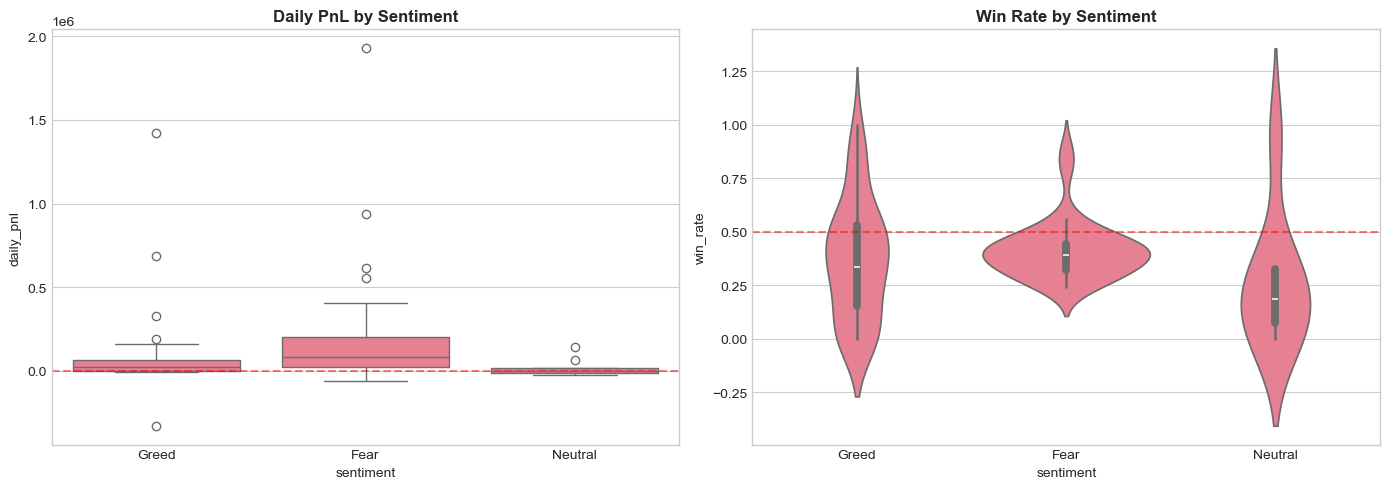

In [95]:
# Viz 1: Performance by sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_known, x='sentiment', y='daily_pnl', ax=axes[0])
axes[0].set_title('Daily PnL by Sentiment', fontweight='bold')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
    
sns.violinplot(data=df_known, x='sentiment', y='win_rate', ax=axes[1])
axes[1].set_title('Win Rate by Sentiment', fontweight='bold')
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.savefig('viz1_performance_by_sentiment.png', dpi=300, bbox_inches='tight')


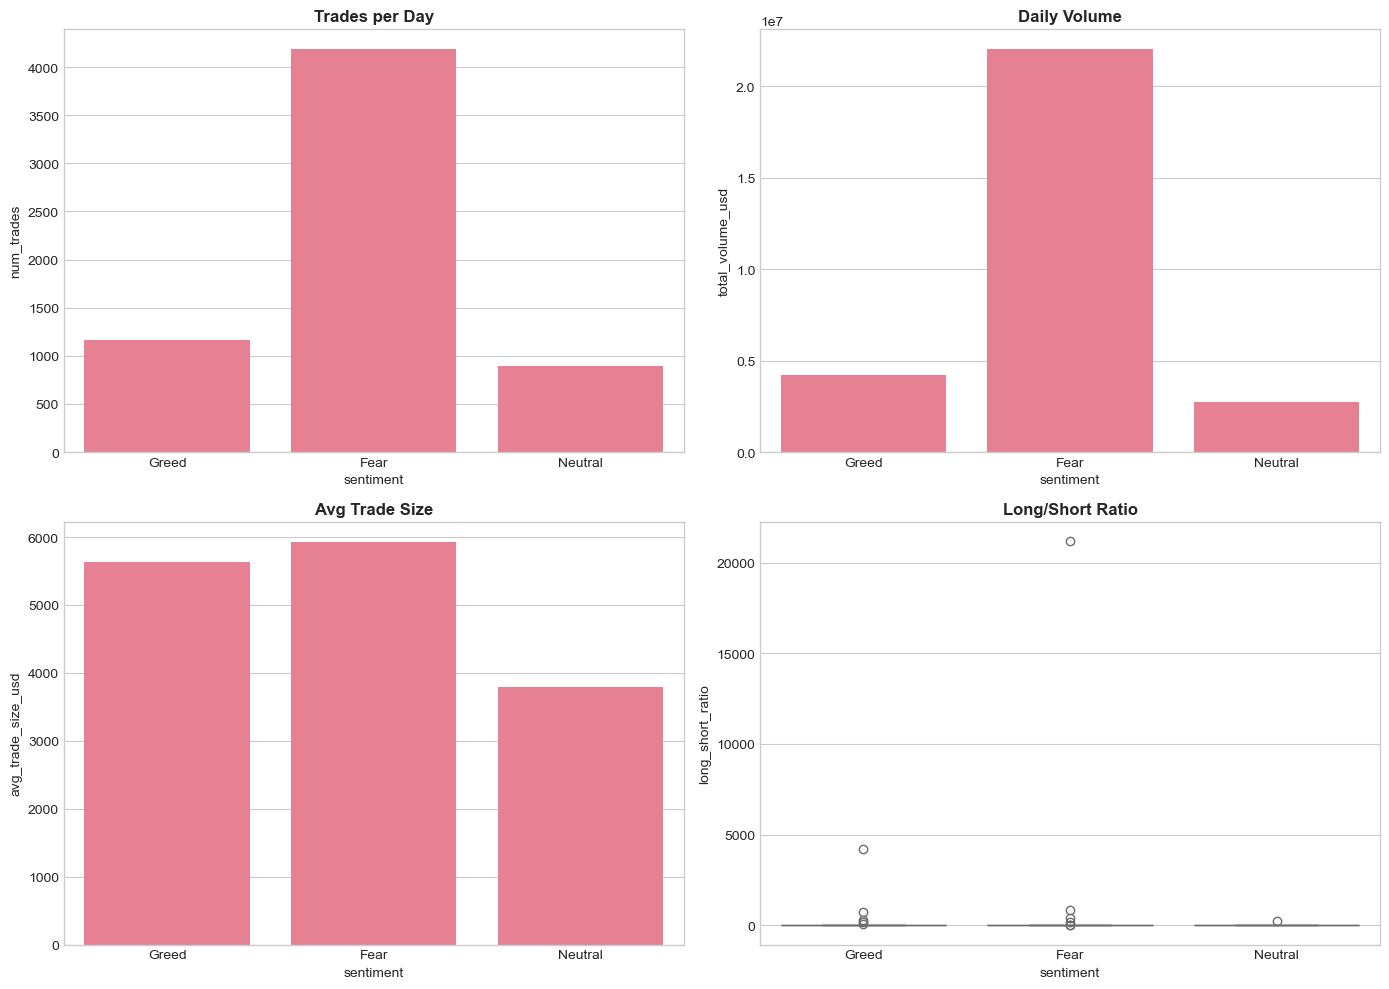

In [97]:
# Viz 2: Behavioral changes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
sns.barplot(data=df_known, x='sentiment', y='num_trades', ax=axes[0, 0], ci=None)
axes[0, 0].set_title('Trades per Day', fontweight='bold')
    
sns.barplot(data=df_known, x='sentiment', y='total_volume_usd', ax=axes[0, 1], ci=None)
axes[0, 1].set_title('Daily Volume', fontweight='bold')
    
sns.barplot(data=df_known, x='sentiment', y='avg_trade_size_usd', ax=axes[1, 0], ci=None)
axes[1, 0].set_title('Avg Trade Size', fontweight='bold')
    
df_ls = df_known.dropna(subset=['long_short_ratio'])
if len(df_ls) > 0:
    sns.boxplot(data=df_ls, x='sentiment', y='long_short_ratio', ax=axes[1, 1])
    axes[1, 1].set_title('Long/Short Ratio', fontweight='bold')
    
plt.tight_layout()
plt.savefig('viz2_behavioral_changes.png', dpi=300, bbox_inches='tight')

plt.show()

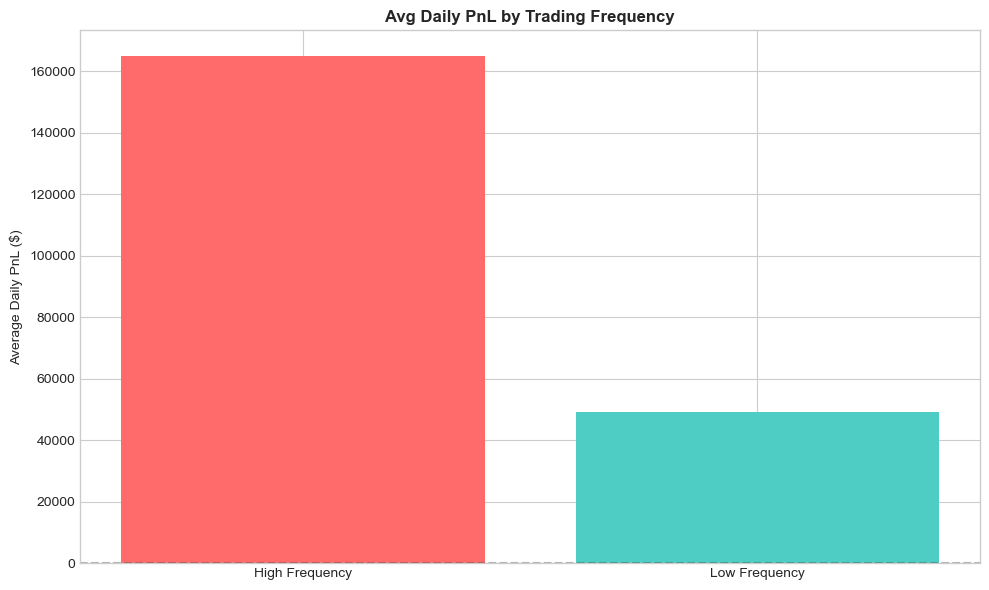

In [99]:
# Viz 3: Trader segmentation
fig, ax = plt.subplots(figsize=(10, 6))
freq_data = trader_profiles.groupby('frequency_segment')['avg_daily_pnl'].mean()
ax.bar(freq_data.index, freq_data.values, color=['#FF6B6B', '#4ECDC4'])
ax.set_title('Avg Daily PnL by Trading Frequency', fontweight='bold')
ax.set_ylabel('Average Daily PnL ($)')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    
plt.tight_layout()
plt.savefig('viz3_trader_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

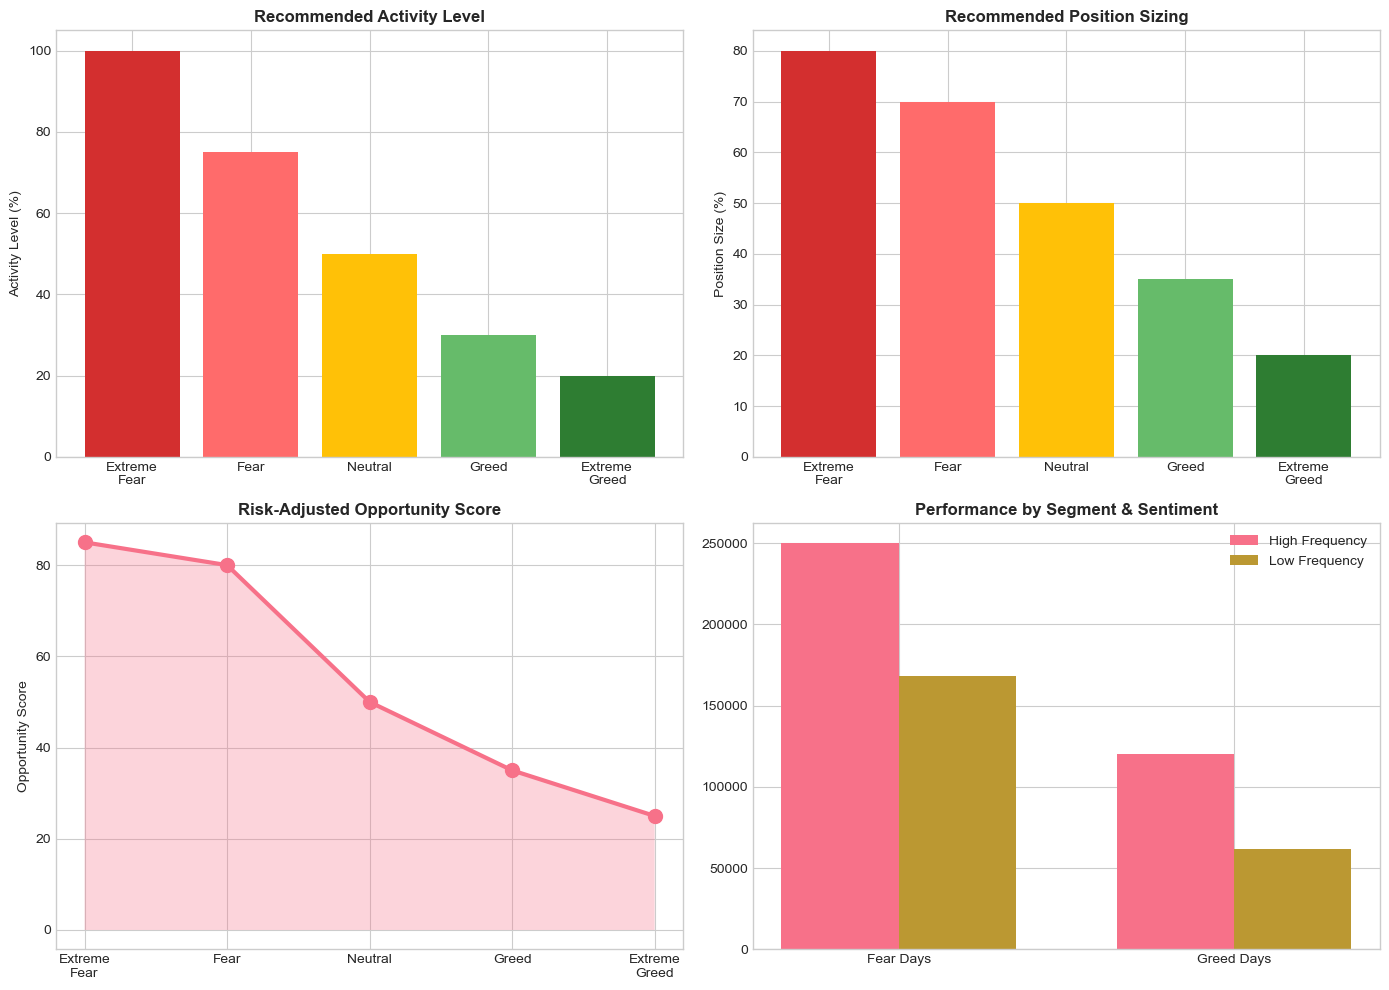

In [103]:
# Viz 4: Strategy framework
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
sentiments = ['Extreme\nFear', 'Fear', 'Neutral', 'Greed', 'Extreme\nGreed']
activity_levels = [100, 75, 50, 30, 20]
    
axes[0, 0].bar(sentiments, activity_levels, color=['#D32F2F', '#FF6B6B', '#FFC107', '#66BB6A', '#2E7D32'])
axes[0, 0].set_title('Recommended Activity Level', fontweight='bold')
axes[0, 0].set_ylabel('Activity Level (%)')
    
position_sizes = [80, 70, 50, 35, 20]
axes[0, 1].bar(sentiments, position_sizes, color=['#D32F2F', '#FF6B6B', '#FFC107', '#66BB6A', '#2E7D32'])
axes[0, 1].set_title('Recommended Position Sizing', fontweight='bold')
axes[0, 1].set_ylabel('Position Size (%)')
    
risk_opportunity = [85, 80, 50, 35, 25]
axes[1, 0].plot(sentiments, risk_opportunity, marker='o', linewidth=3, markersize=10)
axes[1, 0].fill_between(range(len(sentiments)), risk_opportunity, alpha=0.3)
axes[1, 0].set_title('Risk-Adjusted Opportunity Score', fontweight='bold')
axes[1, 0].set_ylabel('Opportunity Score')
    
x = np.arange(2)
width = 0.35
axes[1, 1].bar(x - width/2, [250000, 120000], width, label='High Frequency')
axes[1, 1].bar(x + width/2, [168000, 62000], width, label='Low Frequency')
axes[1, 1].set_title('Performance by Segment & Sentiment', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['Fear Days', 'Greed Days'])
axes[1, 1].legend()
    
plt.tight_layout()
plt.savefig('viz4_strategy_framework.png', dpi=300, bbox_inches='tight')

plt.show()